In [2]:
import datetime
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
from palettable import colorbrewer
import matplotlib as mpl
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.examples.arrows import sample_data
#for movie
import holoviews as hv
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from palettable import colorbrewer
from sklearn.cluster import DBSCAN


In [4]:
#climatology
dir_data = 'F:/data/sat_data/oscar/L4/oscar_third_deg/'
filename = dir_data + 'climatology_1993_2018_monthly_data_oscar.nc'
ds=xr.open_dataset(filename)
ds.close()
ds = ds.sel(lon=slice(110,250),lat=slice(65,5))
#    masked = ds_in.where(np.isfinite(clim_in))
ds.plot()


FileNotFoundError: [Errno 2] No such file or directory: b'F:\\data\\sat_data\\oscar\\L4\\oscar_third_deg\\climatology_1993_2018_monthly_data_oscar.nc'

In [3]:
#5-day data
dir_data = 'F:/data/sat_data/oscar/L4/oscar_third_deg/'
for lyr in range(1993,2018): #2019): #2017):
    filename = dir_data + 'oscar_vel' + str(lyr).zfill(4) + '.nc'
    ds=xr.open_dataset(filename,drop_variables=['um','vm'])
   # ds = ds.rename({'longitude':'lon','latitude':'lat'})
    ds = ds.drop('year')
    ds['spd']=np.sqrt(ds.u*ds.u+ds.v*ds.v)
    ds_subset = ds.sel(longitude=slice(110,250),latitude=slice(65,0))
    ds.close()
    if lyr==1993:
        ds_all = ds_subset
    else:
        ds_all=xr.concat([ds_all,ds_subset],'time')
   

ValueError: dimensions or multi-index levels ['longitude', 'latitude'] do not exist

In [52]:
#put 5 day data into one big array or next section is for monthly (smaller)
#I'd like to use xarray open_mfdataset rather than loop over all the files but the files are not
#formatted correctly.  there is both year and time for some reason and it confuses the concat.
#put monthly data into one big array
#dir_data = 'F:/data/sat_data/oscar/L4/oscar_third_deg/*.nc'
#ds_all2 = xr.open_mfdataset(dir_data, chunks=None, concat_dim='time')
#ds_all2 = ds_all2.sel(depth=15)

#so instead, let's loop....

#put monthly data into one big array
dir_data = 'F:/data/sat_data/oscar/L4/oscar_third_deg/'
for lyr in range(1993,2018): #2019): #2017):
    filename = dir_data + str(lyr) + 'monthly_data_oscar.nc'
    ds=xr.open_dataset(filename)
    ds_subset = ds.sel(lon=slice(120,250),lat=slice(65,15))
    ds.close()
    if lyr==1993:
        ds_all = ds_subset
    else:
        ds_all=xr.concat([ds_all,ds_subset],'time')
ds_all = ds_all.sel(depth=15)

ValueError: dimensions or multi-index levels ['depth'] do not exist

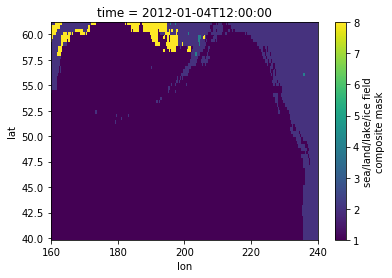

In [133]:
#get a lank mask for the oscar data
ds=xr.open_dataset('F:/data/sst/cmc/CMC0.2deg/v2/2012/004/20120104120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc')
ds.close()
ds = ds.mask.isel(time=0)
ds.coords['lon'] = np.mod(ds['lon'], 360)
ds = ds.sortby(ds.lon)
landmask = ds.interp_like(ds_all,method='nearest')
landmask.plot()

In [134]:
ds_all['mask']=landmask

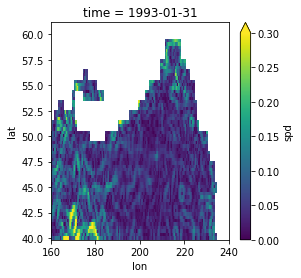

In [135]:
fig, axarr = plt.subplots(1,1,figsize=(4,4))
ds_all.spd[0,:,:].plot(vmin=0,vmax=.3)
fig.savefig('F:/data/NASA_biophysical/telecon_figs/' + 'map.png', dpi=100)

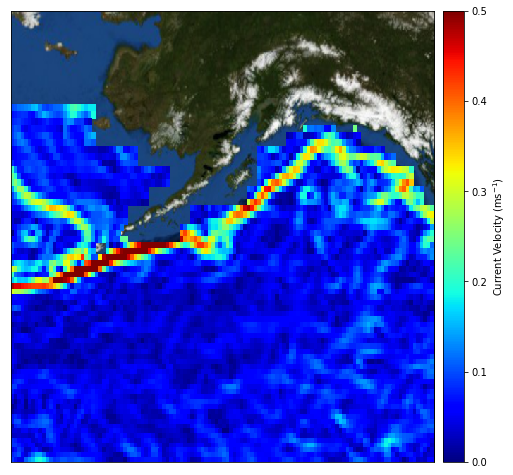

In [136]:
fig = plt.figure(figsize=(11.7,8.3))
ds_subset = ds_all.sel(lon=slice(180,225),lat=slice(65,40))
ds_subset.coords['lon'] = (ds_subset.coords['lon'] + 180) % 360 - 180
m = Basemap(projection='merc', lat_0 = 50, lon_0 = -175,    resolution = 'l', area_thresh = 0.1,
            llcrnrlon=-175, llcrnrlat=40,urcrnrlon=-135, urcrnrlat=65)
m.bluemarble()
#    m.fillcontinents(color='grey',lake_color='white')
lon_grid, lat_grid = np.meshgrid(ds_subset.lon, ds_subset.lat)
x,y = m(lon_grid,lat_grid)
cs = m.pcolormesh(x,y, ds_subset.spd[120,:,:], cmap='jet', vmin = 0, vmax = .5)
m.colorbar(label='Current Velocity (ms$^{-1}$)')
fig.savefig('F:/data/NASA_biophysical/telecon_figs/current_speed_image_2003.png', dpi=100)


In [147]:
ds_subset = ds_all.sel(lon=slice(120,250),lat=slice(65,40))
ds_subset.coords['lon'] = (ds_subset.coords['lon'] + 180) % 360 - 180
plt.figure(figsize=(13,6.2))
ax = plt.subplot(111, projection=ccrs.Mercator(central_longitude=180,min_latitude=40, max_latitude=65))
ax.background_img(name='ne_shaded', resolution='low')
#ax.background_img(name='BM', resolution='high')
ax.set_extent([130,-122,40,65])
mm = ax.pcolormesh(ds_subset.lon,ds_subset.lat,ds_subset.spd[120,:,:],vmin=0, vmax=.5, transform=ccrs.PlateCarree(),cmap='jet' )
ax.coastlines(resolution='10m');
plt.title(str(ds_subset.time[120].data))
plt.colorbar(mm,ax=ax,shrink=.7,pad=.01,label='Current Velocity (ms$^{-1}$)')
fig.savefig('F:/data/NASA_biophysical/telecon_figs/map_NPac_day20030131.png', dpi=100)


ValueError: not enough values to unpack (expected 4, got 0)

In [ ]:
#plot mean and std
ds_subset = ds_all.sel(lon=slice(165,240),lat=slice(62,40))
plt.subplots(1,1,figsize=(13,6.2))
#fig, axarr = plt.subplots(1,1,figsize=(12,3.5))
gs1 = gridspec.GridSpec(1, 2)
ax = plt.subplot(gs1[0],projection=ccrs.Mercator(central_longitude=180,min_latitude=48, max_latitude=62))
ax.background_img(name='ne_shaded', resolution='low')
#ax.background_img(name='BM', resolution='high')
ax.set_extent([165,-122,40,62])
mm = ax.pcolormesh(ds_subset.lon,ds_subset.lat,ds_subset.spd.mean('time'),vmin=0, vmax=.15, transform=ccrs.PlateCarree(),cmap='viridis' )
ax.coastlines(resolution='10m');
plt.title('Current Velocity')
plt.colorbar(mm,ax=ax,shrink=.3,pad=.01,label='Mean(ms$^{-1}$)')

ax = plt.subplot(gs1[1],projection=ccrs.Mercator(central_longitude=180,min_latitude=48, max_latitude=62))
ax.background_img(name='ne_shaded', resolution='low')
#ax.background_img(name='BM', resolution='high')
ax.set_extent([165,-122,40,62])
mm = ax.pcolormesh(ds_subset.lon,ds_subset.lat,ds_subset.spd.std('time'),vmin=0, vmax=.06, transform=ccrs.PlateCarree(),cmap='viridis' )
ax.coastlines(resolution='10m');
plt.title('Current Velocity')
plt.colorbar(mm,ax=ax,shrink=.3,pad=.01,label='STD (ms$^{-1}$)')

#,projection=ccrs.PlateCarree(central_longitude=icenter))
#ax.pcolormesh(ds_subset.lon,ds_subset.lat,ds_subset.spd.mean('time'),vmin=0,vmax=.2)
#plt.plot(ds_subset.lon,ds_subset.lat[curr_max_location],'r',markersize=2)
#ax = plt.subplot(gs1[1])
#ax.pcolormesh(ds_subset.lon,ds_subset.lat,ds_subset.spd.std('time'),vmin=0,vmax=.05)
#plt.plot(ds_subset.lon,ds_subset.lat[curr_max_location],'r',markersize=2)
#plt.plot(ds_subset.lon,ds_subset.lat[curr_max_location-2],'k',markersize=2)
#plt.plot(ds_subset.lon,ds_subset.lat[lower_boundary_index+1],'k',markersize=2)
plt.savefig('F:/data/NASA_biophysical/telecon_figs/mean_std_current_speed.png', dpi=100)


In [ ]:
ds_subset = ds_all.sel(lon=slice(165,228),lat=slice(62,48))
#ds_subset.coords['lon'] = (ds_subset.coords['lon'] + 180) % 360 - 180
#ds_subset = ds_subset.sortby(ds_subset.lon)
ax = plt.subplot(gs1[0],projection=ccrs.Mercator(central_longitude=180,min_latitude=48, max_latitude=62))
ax.background_img(name='ne_shaded', resolution='low')
ax.set_extent([165,-122,48,62])
#xlon=ds_subset.lon.copy(deep=True); xlon[xlon>180]-=360
#mm = ax.pcolormesh(ds_subset.lon,ds_subset.lat,ds_subset.spd.mean('time'),vmin=0, vmax=.2, transform=ccrs.PlateCarree(),cmap='viridis' )
ax.plot(ds_subset.lon,ds_subset.lat[curr_max_location],'r.',linewidth=20,markersize=10, transform=ccrs.PlateCarree())


In [ ]:
ds_subset = ds_all.sel(lon=slice(165,228),lat=slice(61,48))
#ds_subset.coords['lon'] = (ds_subset.coords['lon'] + 180) % 360 - 180
#ds_subset = ds_subset.sortby(ds_subset.lon)
curr_mean = ds_subset.spd.mean('time')
curr_mean2=curr_mean.where((curr_mean.lon<180) & (curr_mean.lat<53) | (curr_mean.lon>180) & (curr_mean.lat<62))
#i don't understand why but the where above which is just to mask out the arctic ocean area for some
#reason sets the 180 longitude to zero so I reset it to the values manually
curr_mean2[:,45]=curr_mean[:,45]
curr_max = curr_mean2.max('lat')
curr_max_location = np.argmax(curr_mean2,0)
curr_std = ds_subset.spd.std('time')
cmask = curr_std.where(curr_std>=0.048)
[lon2d,lat2d]=np.meshgrid(cmask.lon,cmask.lat)
lat2dm = np.where(np.isnan(cmask), lat2d*np.nan,lat2d)
lower_boundary = np.nanmin(lat2dm,0)
lower_boundary_index = np.nanargmin(lat2dm,0)
plt.subplots(1,1,figsize=(13,6.2))
#fig, axarr = plt.subplots(1,1,figsize=(12,3.5))
gs1 = gridspec.GridSpec(1, 2)
ax = plt.subplot(gs1[0],projection=ccrs.Mercator(central_longitude=180,min_latitude=48, max_latitude=62))
ax.background_img(name='ne_shaded', resolution='low')
#ax.background_img(name='BM', resolution='high')
ax.set_extent([165,-122,48,62])
mm = ax.pcolormesh(ds_subset.lon,ds_subset.lat,ds_subset.spd.mean('time'),vmin=0, vmax=.2, transform=ccrs.PlateCarree(),cmap='viridis' )
ax.plot(ds_subset.lon,ds_subset.lat[curr_max_location],'r',markersize=2,linewidth=2, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m');
#plt.title(str(ds_subset.time[120].data))
plt.colorbar(mm,ax=ax,shrink=.3,pad=.01,label='Current Velocity Mean(ms$^{-1}$)')

ax = plt.subplot(gs1[1],projection=ccrs.Mercator(central_longitude=180,min_latitude=48, max_latitude=62))
ax.background_img(name='ne_shaded', resolution='low')
#ax.background_img(name='BM', resolution='high')
ax.set_extent([165,-122,48,62])
mm = ax.pcolormesh(ds_subset.lon,ds_subset.lat,ds_subset.spd.std('time'),vmin=0, vmax=.05, transform=ccrs.PlateCarree(),cmap='viridis' )
ax.plot(ds_subset.lon,ds_subset.lat[curr_max_location],'r',markersize=2,linewidth=2, transform=ccrs.PlateCarree())
ax.plot(ds_subset.lon,ds_subset.lat[curr_max_location-2],'k',markersize=2,linewidth=2, transform=ccrs.PlateCarree())
ax.plot(ds_subset.lon,ds_subset.lat[lower_boundary_index],'k',markersize=2,linewidth=2, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m');
#plt.title(str(ds_subset.time[120].data))
plt.colorbar(mm,ax=ax,shrink=.3,pad=.01,label='Current Velocity STD (ms$^{-1}$)')
plt.savefig('F:/data/NASA_biophysical/telecon_figs/mean_std_current_speed_mask.png', dpi=100)

In [ ]:
#create a mask usin the upper and lower limits
ds_subset['mask_alaskan_stream']=ds_subset['spd'].copy(deep=True)*np.nan
print(ds_subset.mask_alaskan_stream.shape)
for i in range(0,ds_subset.lon.size):
    l1=lower_boundary_index[i].astype(int)
    l2=curr_max_location[i].astype(int).data-2
    #print(l1,l2)
    ds_subset['mask_alaskan_stream'][:,0:l2+1,i]=1
    ds_subset['mask_alaskan_stream'][:,l1:,i]=1
    

In [ ]:
plt.clf()
ds_masked = ds_subset.where(np.isnan(ds_subset.mask_alaskan_stream))  #this will mask out all data 
curr_max = ds_masked.spd.max('lat')
curr_max.attrs={'standard_name':'current velocity (cm/s)'}
curr_max.plot(vmin=0,vmax=0.5,cmap='seismic')
plt.savefig('F:/data/NASA_biophysical/telecon_figs/max_curr_AS_hovmuller.png', dpi=100)


In [ ]:
#remove annual cycle
climatology = curr_max.groupby('time.month').mean('time')
anomalies = curr_max.groupby('time.month') - climatology
anomalies.attrs={'standard_name':'current velocity seasonal cycle removed(cm/s)'}
anomalies.plot(vmin=-0.2,vmax=0.2,cmap='jet')
plt.savefig('F:/data/NASA_biophysical/telecon_figs/max_curr_AS_hovmuller_seasonal_cycle_removed.png', dpi=100)


In [ ]:
curr_max

In [ ]:
ds_masked = ds_subset.where(np.isnan(ds_subset.mask_alaskan_stream))  #this will mask out all data 
ds_filled = ds_subset.fillna(0)  #problem for early data where over land masking produces lots of missing data
curr_max = ds_filled.spd.max('lat')
curr_max_location_time = np.nanargmax(ds_filled.spd,1)  #find the time of the max
plt.pcolormesh(ds_filled.lon,ds_filled.time,curr_max) #,vmin=5,vmax=33)
#plt.pcolormesh(ds_filled.lon,ds_filled.time,curr_max_location,vmin=5,vmax=33)
plt.colorbar(label='index latitude of current maximum')
plt.savefig('F:/data/NASA_biophysical/telecon_figs/max_curr_latitude_index.png', dpi=100)

#find distance from mean location to look at variability

In [ ]:
curr_max_location.shape
print(curr_max_location.shape)
print(curr_max_location_time.shape)
ds_filled

In [ ]:
#caluclate distance from mean location of AS at each longitude and time
import geopy.distance
curr_var = np.zeros((300,ds_subset.lon.size))
for t in range(0,300):
    for i in range(0,ds_subset.lon.size):
        s = np.sign(ds_subset.lat[curr_max_location[i]].data-ds_subset.lat[curr_max_location_time[t,i]].data)
        coords_1 = (ds_subset.lat[curr_max_location[i]],ds_subset.lon[i])  
        coords_2 = (ds_subset.lat[curr_max_location_time[t,i]],ds_subset.lon[i])  
        curr_var[t,i] = s*geopy.distance.geodesic(coords_1, coords_2).km  #distance in km  
ds_tem = xr.DataArray(curr_var,coords={'time': ds_subset.time,'lon':ds_subset.lon}, dims=('time', 'lon'))        

In [ ]:
plt.pcolormesh(ds_subset.lon,ds_subset.time,curr_var,vmin=-200,vmax=200,cmap='seismic')
plt.xlabel('Longitude (deg)')
plt.ylabel('Date')
plt.colorbar(label='distance from mean location (km)')
plt.savefig('F:/data/NASA_biophysical/telecon_figs/max_curr_distance_from_mean.png', dpi=100)


In [ ]:
i=100
np.sign(ds_subset.lat[curr_max_location[i]].data-ds_subset.lat[curr_max_location_time[t,i]].data)

In [ ]:
subset_vel = ds_tem.sel(lon=slice(190,208),time=slice('2000-01-01','2016-12-31'))
subset_vel.plot(vmin=-500,vmax=500,cmap='seismic')

In [ ]:
#look at region and mask out edges so can fit a line better
subset_vel = ds_tem.sel(lon=slice(190,210),time=slice('2002-07-01','2005-01-31'))
subset_vel = subset_vel.where((subset_vel.time<np.datetime64('2003-10')) | (subset_vel.lon<200))
subset_vel = subset_vel.where((subset_vel.time>np.datetime64('2003-07')) | (subset_vel.lon>198))
subset_vel.plot(vmin=-100,vmax=100,cmap='seismic')
plt.plot([210,190],[np.datetime64('2002-07'),np.datetime64('2004-09')],'k')

In [ ]:
svfitx,svfity,svfits,svfitp=np.zeros((5,35)),np.zeros((5,35)),np.zeros(5),np.zeros(5)
ind = subset_vel.where(subset_vel>40, drop=True).squeeze()
xx,yy=[],[]
for i in range(0,ind.shape[0]):
    for j in range(0,ind.shape[1]):
        if np.isnan(ind[i,j]):
            continue
        xx,yy=np.append(xx,ind.lon[j]),np.append(yy,(ind.time[i]-ind.time[0])/np.timedelta64(1, 'D'))
p = np.polyfit(xx,yy,1)
xfit = np.arange(190,225,1) #(0,60,1)
yfit = np.polyval(p,xfit)
tax = (ind.time - ind.time[0])/np.timedelta64(1, 'D')
plt.pcolor(ind.lon,tax,ind)
plt.plot(xfit,yfit,'r')
print(p)
print(xfit[-1],(ind.time[0]+np.timedelta64(int(yfit[-1]),'D')).data)
print('start',((ind.time[0]-np.datetime64('2000-01-01'))/np.timedelta64(1,'D')).data)
svfitx[0,:]=xfit
svfity[0,:]=yfit
svfits[0]=((ind.time[0]-np.datetime64('2000-01-01'))/np.timedelta64(1,'D')).data
svfitp[0]=p[0]

In [ ]:
#look at region and mask out edges so can fit a line better
subset_vel = ds_tem.sel(lon=slice(190,210),time=slice('2003-10-01','2008-01-31'))
subset_vel = subset_vel.where((subset_vel.time<np.datetime64('2006-10')) | (subset_vel.lon<195))
subset_vel = subset_vel.where((subset_vel.time<np.datetime64('2006-07')) | (subset_vel.lon<196))
subset_vel = subset_vel.where((subset_vel.time<np.datetime64('2005-01')) | (subset_vel.lon<207))
subset_vel = subset_vel.where((subset_vel.time<np.datetime64('2005-07')) | (subset_vel.lon<203))
subset_vel = subset_vel.where((subset_vel.time<np.datetime64('2005-03')) | (subset_vel.lon<205))
subset_vel = subset_vel.where((subset_vel.time<np.datetime64('2004-07')) | (subset_vel.lon<209))
subset_vel = subset_vel.where((subset_vel.time>np.datetime64('2005-01')) | (subset_vel.lon>203))
subset_vel.plot(vmin=-100,vmax=100,cmap='seismic')


In [ ]:
ind = subset_vel.where(subset_vel>40, drop=True).squeeze()
xx,yy=[],[]
for i in range(0,ind.shape[0]):
    for j in range(0,ind.shape[1]):
        if np.isnan(ind[i,j]):
            continue
        xx,yy=np.append(xx,ind.lon[j]),np.append(yy,(ind.time[i]-ind.time[0])/np.timedelta64(1, 'D'))
p = np.polyfit(xx,yy,1)
xfit = np.arange(190,225,1) #(0,60,1)
yfit = np.polyval(p,xfit)
tax = (ind.time - ind.time[0])/np.timedelta64(1, 'D')
plt.pcolor(ind.lon,tax,ind)
plt.plot(xfit,yfit,'r')
print(p)
print(xfit[-1],(ind.time[0]+np.timedelta64(int(yfit[-1]),'D')).data)
print('start',((ind.time[0]-np.datetime64('2000-01-01'))/np.timedelta64(1,'D')).data)
svfitx[1,:]=xfit
svfity[1,:]=yfit
svfits[1]=((ind.time[0]-np.datetime64('2000-01-01'))/np.timedelta64(1,'D')).data
svfitp[1]=p[0]

In [ ]:
#look at region and mask out edges so can fit a line better
subset_vel = ds_tem.sel(lon=slice(190,210),time=slice('2006-10-01','2010-01-31'))
subset_vel = subset_vel.where((subset_vel.time<np.datetime64('2009-02')) | (subset_vel.lon<200))
subset_vel = subset_vel.where((subset_vel.time<np.datetime64('2008-01')) | (subset_vel.lon<205))
subset_vel = subset_vel.where((subset_vel.time>np.datetime64('2008-04')) | (subset_vel.lon>200))
subset_vel = subset_vel.where((subset_vel.time>np.datetime64('2007-04')) | (subset_vel.lon>205))
subset_vel = subset_vel.where((subset_vel.time>np.datetime64('2007-03')) | (subset_vel.lon>209))
subset_vel.plot(vmin=-100,vmax=100,cmap='seismic')


In [ ]:
ind = subset_vel.where(subset_vel>40, drop=True).squeeze()
xx,yy=[],[]
for i in range(0,ind.shape[0]):
    for j in range(0,ind.shape[1]):
        if np.isnan(ind[i,j]):
            continue
        xx,yy=np.append(xx,ind.lon[j]),np.append(yy,(ind.time[i]-ind.time[0])/np.timedelta64(1, 'D'))
p = np.polyfit(xx,yy,1)
xfit = np.arange(190,225,1) #(0,60,1)
yfit = np.polyval(p,xfit)
tax = (ind.time - ind.time[0])/np.timedelta64(1, 'D')
plt.pcolor(ind.lon,tax,ind)
plt.plot(xfit,yfit,'r')
print(p)
print(xfit[-1],(ind.time[0]+np.timedelta64(int(yfit[-1]),'D')).data)
print('start',((ind.time[0]-np.datetime64('2000-01-01'))/np.timedelta64(1,'D')).data)
svfitx[2,:]=xfit
svfity[2,:]=yfit
svfits[2]=((ind.time[0]-np.datetime64('2000-01-01'))/np.timedelta64(1,'D')).data
svfitp[2]=p[0]

In [ ]:
#look at region and mask out edges so can fit a line better
subset_vel = ds_tem.sel(lon=slice(190,210),time=slice('2010-01-03','2012-11-01'))
subset_vel = subset_vel.where((subset_vel.time<np.datetime64('2011-10')) | (subset_vel.lon<200))
subset_vel = subset_vel.where((subset_vel.time<np.datetime64('2011-01')) | (subset_vel.lon<207))
subset_vel = subset_vel.where((subset_vel.time>np.datetime64('2010-10')) | (subset_vel.lon>205))
subset_vel.plot(vmin=-100,vmax=100,cmap='seismic')


In [ ]:
ind = subset_vel.where(subset_vel>40, drop=True).squeeze()
xx,yy=[],[]
for i in range(0,ind.shape[0]):
    for j in range(0,ind.shape[1]):
        if np.isnan(ind[i,j]):
            continue
        xx,yy=np.append(xx,ind.lon[j]),np.append(yy,(ind.time[i]-ind.time[0])/np.timedelta64(1, 'D'))
p = np.polyfit(xx,yy,1)
xfit = np.arange(190,225,1) #(0,60,1)
yfit = np.polyval(p,xfit)
tax = (ind.time - ind.time[0])/np.timedelta64(1, 'D')
plt.pcolor(ind.lon,tax,ind)
plt.plot(xfit,yfit,'r')
print(p)
print(xfit[-1],(ind.time[0]+np.timedelta64(int(yfit[-1]),'D')).data)
print('start',((ind.time[0]-np.datetime64('2000-01-01'))/np.timedelta64(1,'D')).data)
svfitx[3,:]=xfit
svfity[3,:]=yfit
svfits[3]=((ind.time[0]-np.datetime64('2000-01-01'))/np.timedelta64(1,'D')).data
svfitp[3]=p[0]

In [ ]:
subset_vel = ds_tem.sel(lon=slice(190,210),time=slice('2011-10-03','2014-07-01'))
subset_vel = subset_vel.where((subset_vel.time<np.datetime64('2014-01')) | (subset_vel.lon<200))
subset_vel = subset_vel.where((subset_vel.time<np.datetime64('2013-07')) | (subset_vel.lon<202))
subset_vel = subset_vel.where((subset_vel.time<np.datetime64('2013-01')) | (subset_vel.lon<204))
subset_vel = subset_vel.where((subset_vel.time>np.datetime64('2012-10')) | (subset_vel.lon>200))
subset_vel.plot(vmin=-100,vmax=100,cmap='seismic')


In [ ]:
ind = subset_vel.where(subset_vel>40, drop=True).squeeze()
xx,yy=[],[]
for i in range(0,ind.shape[0]):
    for j in range(0,ind.shape[1]):
        if np.isnan(ind[i,j]):
            continue
        xx,yy=np.append(xx,ind.lon[j]),np.append(yy,(ind.time[i]-ind.time[0])/np.timedelta64(1, 'D'))
p = np.polyfit(xx,yy,1)
xfit = np.arange(190,225,1) #(0,60,1)
yfit = np.polyval(p,xfit)
tax = (ind.time - ind.time[0])/np.timedelta64(1, 'D')
plt.pcolor(ind.lon,tax,ind)
plt.plot(xfit,yfit,'r')
print(p)
print(xfit[-1],(ind.time[0]+np.timedelta64(int(yfit[-1]),'D')).data)
print('start',((ind.time[0]-np.datetime64('2000-01-01'))/np.timedelta64(1,'D')).data)
svfitx[4,:]=xfit
svfity[4,:]=yfit
svfits[4]=((ind.time[0]-np.datetime64('2000-01-01'))/np.timedelta64(1,'D')).data
svfitp[4]=p[0]

In [ ]:
subset_vel = ds_tem.sel(lon=slice(165,225),time=slice('2000-01-01','2016-12-31'))
tax = (subset_vel.time - subset_vel.time[0])/np.timedelta64(1, 'D')
plt.pcolormesh(subset_vel.lon,tax,subset_vel,vmin=-500,vmax=500,cmap='seismic')
for i in range(0,5):
    plt.plot(svfitx[i,:],svfity[i,:]+svfits[i],'k',label=str(i))
    plt.text(191,svfity[i,0]+svfits[i],str(i))
plt.xlabel('Longitude (deg)')
plt.ylabel('Days from 2000-01-01')
plt.colorbar(label='Distance from mean location (km)')
plt.savefig('F:/data/NASA_biophysical/telecon_figs/eddy_hov.png', dpi=100)
    

In [ ]:
svfitp

In [ ]:
min_lat = np.empty(250)
max_lat = np.empty(250)
#max_lat[185:]=[52.0,52.1,52.1,52.1,54]
for cen_lon in range(165,195):
    fig, axarr = plt.subplots(1,1,figsize=(4,4))
    ds_subset = ds_all.sel(lon=slice(cen_lon,cen_lon),lat=slice(60,50))
    ds_subset.spd[84:,:,:].transpose().plot(vmin=0,vmax=.3)
    fig.savefig('F:/data/NASA_biophysical/telecon_figs/' + 'hov_lon'+str(cen_lon)+'.png', dpi=100)
    fig.clf()


In [ ]:
cen_lon=185
ds_subset = ds_all.sel(lon=slice(cen_lon,cen_lon),lat=slice(60,50))
tem = ds_subset.mean('time').mean('depth').drop('year')
print(tem)
ii = tem.argmax(dim='lat')
ilat = tem.lat[ii.spd].data[0]
print(ilat)

In [ ]:
cen_lon=185
import datetime as dt
svlat=[]
svspd=[]
ilon=195 #for ilon in range(195,285):
cen_lon = ds_all.lon[ilon]
#for this lon find the mean position
ds_subset = ds_all.sel(lon=slice(cen_lon,cen_lon),lat=slice(60,48))
tem = ds_subset.mean('time').mean('depth').drop('year')
ii = tem.argmax(dim='lat')
cen_lat = tem.lat[ii.spd].data[0]
print(cen_lat)
#now look around cen lat for tim variable mean 
ds_subset = ds_all.sel(time=slice(dt.datetime(2000,1,1),dt.datetime(2018,1,1)),lon=slice(cen_lon,cen_lon),lat=slice(cen_lat+2,cen_lat-4))
tem = ds_subset.mean('depth').drop('year')
ii = tem.argmax(dim='lat')
yy = tem.max(dim='lat')
cen_ii_time=ii.spd
cen_lat_time=tem.lat[ii.spd]
cen_lat_spd=yy.spd
print(cen_lat_time.mean())
cen_lat_time.plot()
svlat.append(cen_lat_time)
svspd.append(cen_lat_spd)



In [ ]:
tem

In [ ]:
tem.spd[:,:,0].plot()

In [ ]:
cen_lat_time.plot()

In [ ]:
ds_all.spd[10,0,:,:].plot()
print(ds_all.lon[195])

In [ ]:

ilon,itime=195,180 #for ilon in range(195,285):
cen_lon = ds_all.lon[ilon]
ds_subset = ds_all.sel(lon=slice(cen_lon,cen_lon),lat=slice(60,47.3))
ds_all.spd[itime,0,:,ilon].plot()
ds_subset.spd[itime,0,:,0].plot()
ds_smooth = ds_subset.rolling(time=4).mean()
ds_smooth.spd[itime,0,:,0].plot()  #smooth data
tem = ds_subset.mean('time').mean('depth').drop('year')
ii = tem.argmax(dim='lat')
cen_lat = tem.lat[ii.spd].data[0]
cen_spd = tem.spd[ii.spd].data[0]
plt.plot(cen_lat,cen_spd,'b.')
print(cen_lat,cen_spd)
#now look around cen lat for tim variable mean 
ds_subset = ds_all.sel(time=slice(dt.datetime(2000,1,1),dt.datetime(2018,1,1)),lon=slice(cen_lon,cen_lon),lat=slice(cen_lat+2,cen_lat-4))
tem = ds_subset.mean('depth').drop('year')
ii = tem.argmax(dim='lat')
yy = tem.max(dim='lat')
cen_ii_time=ii.spd
cen_lat_time=tem.lat[ii.spd]
cen_lat_spd=yy.spd
#print(cen_lat_time)
print(cen_lat_time.mean())
#cen_lat_time.plot()
plt.plot(cen_lat_time.mean(),cen_lat_spd.mean(),'r.')

In [ ]:
cen_lat_time[10,0]

In [ ]:
ilon=195
cen_lon = ds_all.lon[ilon]
#for this lon find the mean position
ds_subset = ds_all.sel(lon=slice(cen_lon,cen_lon),lat=slice(60,48))
ds_subset.spd[86,0,:,0].plot()

In [ ]:
ds_subset.spd[0,:]

In [ ]:
fig, axarr = plt.subplots(1,1,figsize=(4,4))
ds_subset = ds_all.sel(lon=slice(180,180),lat=slice(65,45))
ds_subset.spd[:,0,:,:].transpose().plot(vmin=0,vmax=.3)
fig.savefig('F:/data/NASA_biophysical/telecon_figs/' + 'hov_lon180.png', dpi=100)


In [ ]:
fig, axarr = plt.subplots(1,1,figsize=(4,4))
ds_subset = ds_all.sel(lon=slice(190,190),lat=slice(65,45))
ds_subset.spd[:,0,:,:].transpose().plot(vmin=0,vmax=.3)
fig.savefig('F:/data/NASA_biophysical/telecon_figs/' + 'hov_lon190.png', dpi=100)



In [ ]:
fig, axarr = plt.subplots(1,1,figsize=(4,4))
ds_subset = ds_all.sel(lon=slice(200,200),lat=slice(65,45))
ds_subset.spd[:,0,:,:].transpose().plot(vmin=0,vmax=.3)
fig.savefig('F:/data/NASA_biophysical/telecon_figs/' + 'hov_lon200.png', dpi=100)


In [ ]:
fig, axarr = plt.subplots(1,1,figsize=(4,4))
ds_subset = ds_all.sel(lon=slice(210,210),lat=slice(65,45))
ds_subset.spd[:,0,:,:].transpose().plot(vmin=0,vmax=.3)
fig.savefig('F:/data/NASA_biophysical/telecon_figs/' + 'hov_lon210.png', dpi=100)


In [ ]:
fig, axarr = plt.subplots(1,1,figsize=(4,4))
ds_subset = ds_all.sel(lon=slice(180,210),lat=slice(58,47.5))
ds_subset.spd[:,0,:,:].max('lat').transpose().plot(vmin=0,vmax=0.5)
fig.savefig('F:/data/NASA_biophysical/telecon_figs/' + 'max_spd_180_210.png', dpi=100)


In [ ]:
fig, axarr = plt.subplots(1,1,figsize=(4,4))
ds_subset = ds_all.sel(lon=slice(220,245),lat=slice(42,42))
ds_subset.spd[:,0,:,:].transpose().plot(vmin=0,vmax=.15)
fig.savefig('F:/data/NASA_biophysical/telecon_figs/' + 'hov_lat42.png', dpi=100)


In [ ]:
ds_all

In [ ]:
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ds_all.spd[0,0,:,:].plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),vmin=-1,vmax=1,cmap='seismic');
ax.set_global(); ax.coastlines();
ax.set_xlim(-80,70)
ax.set_ylim(15,65)
fig.savefig('F:/data/NASA_biophysical/telecon_figs/' + 'sample_plot.png', dpi=100)


In [ ]:
pwd

In [ ]:
#make a movie of the monthly images
#would like to plot mean location, monthly locations, eddies
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
#plt.rcParams['animation.ffmpeg_path'] = 'c:/FFmpeg/bin/'
plt.rcParams['animation.ffmpeg_path'] ='C:\\FFmpeg\\bin\\ffmpeg.exe'
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

ilen = ds_subset.time.shape[0]
ds_subset = ds_all.sel(time=slice(np.datetime64('2000-01-01'),np.datetime64('2018-12-31')),lon=slice(175,228),lat=slice(62,48),depth=15)

fig, ax0 = plt.subplots(1,1,figsize=(4,4))
im=ax0.pcolormesh(ds_subset.lon,ds_subset.lat,ds_subset.spd[0,:,:],vmin=0,vmax=.3)
fig.colorbar(im,ax=ax0)
with writer.saving(fig, "F:/data/NASA_biophysical/movies/writer_test.mp4", 100):
    for i in range(ilen):
        fig, ax0 = plt.subplots(1,1,figsize=(4,4))
        im=ax0.pcolormesh(ds_subset.lon,ds_subset.lat,ds_subset.spd[i,:,:],vmin=0,vmax=.3)
        fig.colorbar(im,ax=ax0)
        writer.grab_frame()

In [ ]:
def plot_pcolor(lons,lats):

    class UpdateQuad(object):

        def __init__(self,ax, map_object, lons, lats):
            self.ax = ax
            self.m  = map_object
            self.lons = lons
            self.lats = lats
            vmin = 0
            vmax = 1
            self.ydim, self.xdim = lons.shape

            self.z = np.zeros((self.ydim-1,self.xdim-1))

            levels = MaxNLocator(nbins=15).tick_values(vmin,vmax)
            cmap = plt.cm.cool
            norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
            x, y = self.m(lons, lats)

            self.quad = self.ax.pcolormesh(x, y, self.z, alpha=0.9,
                                           norm=norm, cmap=cmap,
                                           vmin=vmin, vmax=vmax)
        def init(self):
            print('update init')
            self.quad.set_array(np.asarray([]))
            return self.quad

        def __call__(self,i):

            for i in range(self.ydim-1):
                for j in range(self.xdim-1):
                    self.z[i,j]=random.random()

            self.quad.set_array(self.z.ravel())

            return self.quad


    fig, ax = plt.subplots()

    m = Basemap(width=2000000,height=2000000,
                resolution='l', projection='laea',\
                lat_ts=10.,\
                lat_0=64.,lon_0=10., ax=ax)

    m.fillcontinents()

    ud = UpdateQuad(ax, m, lons, lats)

    anim = animation.FuncAnimation(fig, ud, init_func=ud.init,
                                   frames=20,  blit=False)

    fig.tight_layout()

    plt.show()

    return ud.quad

if __name__ == '__main__':
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    from mpl_toolkits.basemap import Basemap
    import numpy as np
    import random
    from matplotlib.colors import BoundaryNorm
    from matplotlib.ticker import MaxNLocator

    lons = np.linspace(-5.,25., num = 25)[:50]
    lats = np.linspace(56., 71., num = 25)[:50]
    lons,lats =  np.meshgrid(lons,lats)

    quad = plot_pcolor(lons,lats)

In [ ]:
from matplotlib.animation import FuncAnimation

# Some global variables to define the whole run
total_number_of_frames = ds_subset.time.shape[0]

def animate(frame):
#    """
#    Animation function. Takes the current frame number (to select the potion of
#    data to plot) and a line object to update.
#    """
    # Not strictly neccessary, just so we know we are stealing these from
    # the global scope
    global ds_subset, image
    # We want up-to and _including_ the frame'th element
    image.set_array(ds_subset[frame,:,:])
    return image

# Now we can do the plotting!
fig, ax = plt.subplots(1, figsize=(1, 1))
# Remove a bunch of stuff to make sure we only 'see' the actual imshow
# Stretch to fit the whole plane
fig.subplots_adjust(0, 0, 1, 1)
# Remove bounding line
ax.axis("off")
# Initialise our plot. Make sure you set vmin and vmax!
image = ax.imshow(ds_subset.spd[0,:,:], vmin=0, vmax=.5)

animation = FuncAnimation(
    # Your Matplotlib Figure object
    fig,
    # The function that does the updating of the Figure
    animate,
    # Frame information (here just frame number)
    np.arange(total_number_of_frames),
    # Extra arguments to the animate function
    fargs=[],
    # Frame-time in ms; i.e. for a given frame-rate x, 1000/x
    interval=1000 / 25
)

# Try to set the DPI to the actual number of pixels you're plotting
animation.save("F:/data/NASA_biophysical/movies/writer_test2.mp4", dpi=100)

In [ ]:
#try to make movie
ds_all
hv.extension('bokeh')


In [ ]:
ds_all

In [ ]:
%%output holomap='scrubber'
%%opts Image style(cmap='rainbow') plot[colorbar=True]
%%opts Image [width=500, height=400]
opts = dict(cmap='rainbow', colorbar=True, width=300, height=230, axiswise=True)
hv_ds = hv.Dataset(ds_all.spd[1:150,0,:,:])
img = hv_ds.to(hv.Image, ['lon', 'lat']).options(**opts)
#img.options(colorbar=True, width=300, height=230, axiswise=True)
img.redim.range(spd=(0,.5))


In [ ]:
hv.save(img, 'Spd_half_A.html')

In [ ]:
%%output holomap='scrubber'
%%opts Image style(cmap='viridis') plot[colorbar=True]
%%opts Image [width=500, height=400]
opts = dict(cmap='rainbow', colorbar=True, width=300, height=230, axiswise=True)
hv_ds = hv.Dataset(ds_all.spd[100:300,0,:,:])
img = hv_ds.to(hv.Image, ['lon', 'lat']).options(**opts)
#img.options(colorbar=True, width=300, height=230, axiswise=True)
img.redim.range(spd=(0,.5))


In [ ]:
hv.save(img, 'Spd_half_B.html', backend='bokeh')

In [ ]:
hv.extension('matplotlib')

air = xr.tutorial.load_dataset('air_temperature')
ds = hv.Dataset(air.isel(time=range(100)))
images = ds.to(hv.Image, ['lon', 'lat']).options(fig_inches=(10, 5), colorbar=True, cmap='viridis')


In [ ]:
#Y, X = np.meshgrid(ds.latitude, ds.longitude)
#ds = ds.sel(longitude=slice(110,250),latitude=slice(65,15))
import matplotlib as mpl
import matplotlib.colors as colors
for imon in range (5,6): #13):
    #ds = ds.sel(lon=slice(110,250),lat=slice(65,15))
    X = ds.lon.values
    Y = ds.lat.values
    U = ds.u[imon,0,:,:]
    V = ds.v[imon,0,:,:]
    speed = np.sqrt(U*U + V*V)
    speed = speed.fillna(0)
    lws = 10*speed / speed.max()

    fig0, ax0 = plt.subplots()
    strm = ax0.streamplot(X,Y, U, V, density=6,color=V.values,linewidth=lws.values, cmap='seismic',norm=colors.Normalize(vmin=-.5,vmax=.5))
    fig0.colorbar(strm.lines)


In [ ]:
    ds2 = ds.sel(lon=slice(110,179),lat=slice(65,5))
    lons1 = ds2.lon.values
    lons1[lons1 > 180] = lons1[lons1 > 180] - 360.  #wrap -180-180
    lats1 = ds2.lat.values
    
#    lons0, lats0 = np.meshgrid(lons1,lats1)
    X = lons1 
    Y = lats1
    U = ds2.u[imon,0,:,:]
    V = ds2.v[imon,0,:,:]
    speed = np.sqrt(U*U + V*V)
    speed = speed.fillna(0)
    lws = 10*speed / speed.max()
    
    Xg, Yg = np.meshgrid(X,Y)
    input_projection = ccrs.PlateCarree()
    #ax = plt.subplot(projection=output_projection)
    #ax.streamplot(X, Y, U, V, transform=input_projection)
#    ax0 = plt.axes(projection=ccrs.PlateCarree())
#    ax0 = fig0.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180.0))
#    ax0.set_extent([-110, 110, 5, 65], crs=ccrs.PlateCarree(central_longitude=180.0))
#    ax0.coastlines()

#    fig0, ax0 = plt.subplots()

    #fig0, ax0 = plt.subplots()
    #ax0 = plt.axes(projection=ccrs.PlateCarree())
    ax0 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    strm = ax0.streamplot(X,Y, U, V, density=6,color=V.values,linewidth=lws.values, cmap='seismic',norm=colors.Normalize(vmin=-.5,vmax=.5), transform = input_projection)
    fig0.colorbar(strm.lines)

    #fig0, ax0 = plt.figure(figsize=(10, 5))
    #strm = ax0.streamplot(X,Y, U, V, density=6,color=V.values,linewidth=lws.values, cmap='seismic',
    #                      norm=colors.Normalize(vmin=-.5,vmax=.5)) #, transform=input_projection)
#    ax0.coastlines()
#    fig0.colorbar(strm.lines)


In [ ]:
X

In [ ]:
#Y, X = np.meshgrid(ds.latitude, ds.longitude)
#ds = ds.sel(longitude=slice(110,250),latitude=slice(65,15))

for imon in range (5,6): #13):
    #ds = ds.sel(lon=slice(110,250),lat=slice(65,15))
    lons1 = ds.lon.values
    lons1[lons1 > 180] = lons1[lons1 > 180] - 360.  #wrap -180-180
    lats1 = ds.lat.values
    
#    lons0, lats0 = np.meshgrid(lons1,lats1)
    X = lons1 
    Y = lats1
    U = ds.u[imon,0,:,:]
    V = ds.v[imon,0,:,:]
    Vnorm = V/abs(V).max()
    speed = np.sqrt(U*U + V*V)
    speed = speed.fillna(0)
    lws = 10*speed / speed.max()
    fig = plt.figure(figsize=(8,8))
#    map = Basemap(projection='cyl',llcrnrlat=lats1[-1],llcrnrlon=lons1[0],
#                  urcrnrlat=lats1[0],urcrnrlon=lons1[-1],resolution='l')

    map = Basemap(projection='lcc', llcrnrlon=110, llcrnrlat=5, 
                  urcrnrlon=-110, urcrnrlat=65,lat_0=5, lon_0=-98.)
    map.drawcoastlines(linewidth=0.5)
    strm = map.streamplot(X,Y, U, V, latlon=True, density=6,color=V.values,linewidth=lws.values, cmap='seismic',norm=colors.Normalize(vmin=-.5,vmax=.5))
    #norm = mpl.colors.Normalize(vmin=-.5,vmax=.5)
    #fig0.colorbar(strm.lines)


In [ ]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=110,urcrnrlon=-110,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary(fill_color='aqua')
plt.title("Equidistant Cylindrical Projection")
plt.show()

In [ ]:
print(Xg.shape,xx.shape,yy.shape,U.shape,V.shape)

In [ ]:
lons = ds.lon.values
lons[lons > 180] = lons[lons > 180] - 360.
lons

In [ ]:
print(X.shape,Y.shape,U.shape,V.shape)

In [ ]:
import matplotlib.animation as animation
X = ds.lon.values
Y = ds.lat.values
U = ds.u[:,0,:,:]
V = ds.v[:,0,:,:]
Vnorm = V/abs(V).max()

fig, ax = plt.subplots()
#data = np.random.rand(2, 25)
l, = ax0.streamplot(X,Y, U, V, density=6,color=Vnorm.values, linewidth=lws.values, cmap='seismic')
line_ani = animation.FuncAnimation(fig, update_line, 25, fargs=(data, l),
                                   interval=50, blit=True)


In [ ]:
print(V.min(),V.max())

In [ ]:

cmap = colorbrewer.get_map('Spectral', 'diverging', 11, reverse=True).mpl_colormap
fig = plt.figure(figsize=(11.7,8.3))
m = Basemap(projection='merc', lat_0 = 40, lon_0 = -179, resolution = 'l', area_thresh = 0.1,
            llcrnrlon=-110.0, llcrnrlat=25.0,urcrnrlon=-114.0, urcrnrlat=38.)
m.bluemarble()
lat_grid, lon_grid = np.meshgrid(ds.lat.values, ds.lon.values)
x,y = m(lon_grid,lat_grid)
cs = m.pcolormesh(x,y, speed.transpose(), cmap=cmap, vmin = 0, vmax = 5)


In [ ]:
import matplotlib.pyplot as plt
# setup Lambert Conformal basemap.
# set resolution=None to skip processing of boundary datasets.
m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution=None,lat_1=2.,lat_2=65,lat_0=50,lon_0=-110.)
m.bluemarble(ax=None, scale=0.25)
plt.show()

In [ ]:
import matplotlib
print(matplotlib.__version__)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

lats1=[-25, 66]
lons1=[60, 179.95]
fig=plt.figure()
fig.set_size_inches((10, 9))

ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

bmap=Basemap(projection='merc',\
        llcrnrlat=lats1[0], llcrnrlon=lons1[0],\
        urcrnrlat=lats1[1], urcrnrlon=lons1[1],\
        lon_0=(lons1[0]+lons1[1])/2.,\
        ax=ax1)

bmap.bluemarble(ax = ax1)

ax1.set_position([0, 0, 0.8, 1])

lats2=[-25,66]
lons2=[-179.95, -150]
bmap=Basemap(projection='merc',\
        llcrnrlat=lats2[0], llcrnrlon=lons2[0],\
        urcrnrlat=lats2[1], urcrnrlon=lons2[1],\
        lon_0=(lons2[0]+lons2[1])/2.,\
        ax=ax2)

bmap.bluemarble(ax = ax2)
ax2.set_position([0.8, 0, 0.2, 1])

ax1.set_aspect('auto')
ax2.set_aspect('auto')

ax1.set_adjustable('datalim')
ax2.set_adjustable('datalim')
ax1.axis('off')
ax2.axis('off')
plt.show()


In [ ]:
ds.u[0,0,:,:].plot()
ds.u[0,0,0,0]

In [ ]:
ds

In [ ]:
#make monthly climatology, need to drop 'year' coordinate value for mean to work right
for lyr in range(1993,2019):
    filename = dir_data + str(lyr) + 'monthly_data_oscar.nc'
    ds=xr.open_dataset(filename)
    ds2 = ds.drop('year')
    if lyr==1993:
        ds_clim = ds2
    else:
        ds_clim = xr.concat([ds_clim,ds2],dim = 'time')
    ds.close()
ds_clim2 = ds_clim.groupby('time.month').mean('time')
ds_clim2.to_netcdf(dir_data + 'climatology_1993_2018_monthly_data_oscar.nc')


In [ ]:
ds

In [ ]:
#make monthly climatology, need to drop 'year' coordinate value for mean to work right
for lyr in range(2000,2019):
    filename = dir_data + str(lyr) + 'monthly_data_oscar.nc'
    ds=xr.open_dataset(filename)
    ds2 = ds.drop('year')
    if lyr==2000:
        ds_clim = ds2
    else:
        ds_clim = xr.concat([ds_clim,ds2],dim = 'time')
    ds.close()
ds_clim2 = ds_clim.groupby('time.month').mean('time')
ds_clim2.to_netcdf(dir_data + 'climatology_2000_2018_monthly_data_oscar.nc')

In [ ]:
#OLD OLD OLD OLD OLD OLD CODE
#make oscar climatology, OLD version of code
#dir_data='F:/data/sat_data/oscar/L4/oscar_third_deg/'
dir_clim='F:/data/sat_data/oscar/L4/oscar_third_deg/climatology/'
dir_data = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/oscar/preview/L4/oscar_third_deg/'
for lyr in range(1993,2018):
    filename = dir_data + 'oscar_vel' + str(lyr).zfill(4) + '.nc.gz'
    ds=xr.open_dataset(filename,drop_variables=['um','vm'])
    ds_count=data_ones(ds)
    #in order to add up the data the time arrays have to be aligned otherwise xarray doesn't know what to do with it
    ds['time'] = ds['time'] - np.datetime64(lyr,'Y')
    ds_count['time'] = ds_count['time'] - np.datetime64(lyr,'Y')
    if lyr==1993:
        ds2=ds.fillna(0)
        ds_count2=ds_count.fillna(0)
        ds_summer=ds2
        ds_counter = ds_count2
    else:
        ds2 = ds.interp_like(ds_summer.time)
        ds_count2 = ds_count.interp_like(ds_summer.time)
        ds2=ds2.fillna(0)
        ds_count2=ds_count2.fillna(0)
        ds_summer=ds_summer + ds2
        ds_counter = ds_counter + ds_count2
    print(lyr)
    print(ds.u.shape)
    print(ds_summer.u.shape)
   # print(ds_counter.u.shape)
   # print(ds.u.shape)
   # print(ds.time.data[0:20])
ds_ave = ds_summer / ds_counter
ds_ave.to_netcdf(dir_clim + 'oscar_v2009_1993_2016_climatology_12202118.nc')

In [ ]:
import datetime as dt
tem_date=dt.datetime(2016,1,15)
print(tem_date)
filename = 'https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/godas/dbss_obml.2016.nc'
#filename = 'F:/data/model_data/godas/dbss_obml.2017.nc'
ds = xr.open_dataset(filename)
ds_storm = ds.interp(time = tem_date)
ds_storm


In [ ]:
            dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
            storm_date = dt.datetime(2015,1,1)
            syr, smon, sdym, sjdy=str(storm_date.year),str(storm_date.month),str(storm_date.day),str(storm_date.timetuple().tm_yday)
            fname_tem='/CCMP_Wind_Analysis_' + syr + smon.zfill(2) + sdym.zfill(2) + '_V02.0_L3.0_RSS.nc'
            ccmp_filename = dir_ccmp + syr + '/M' + smon.zfill(2) + fname_tem      
            ds=xr.open_dataset(ccmp_filename,drop_variables=['nobs'])
            ds

In [ ]:
ds_storm.dbss_obml.plot(vmin=0,vmax=200)

In [ ]:
ds_storm.dbss_obml[0,0]

In [ ]:
#plat around with lon mask for part of region along calif coast
ds_subset = ds_all.sel(lon=slice(165,228),lat=slice(61,48))
curr_mean = ds_subset.spd.mean('time')
curr_mean2=curr_mean.where((curr_mean.lon<180) & (curr_mean.lat<53) | (curr_mean.lon>180) & (curr_mean.lat<62))


In [ ]:
#i don't understand why but the where above which is just to mask out the arctic ocean area for some
#reason sets the 180 longitude to zero so I reset it to the values manually
curr_mean2[:,45]=curr_mean[:,45]
curr_max = curr_mean2.max('lat')
curr_max_location = np.argmax(curr_mean2,0)
curr_std = ds_subset.spd.std('time')
cmask = curr_std.where(curr_std>=0.048)
[lon2d,lat2d]=np.meshgrid(cmask.lon,cmask.lat)
lat2dm = np.where(np.isnan(cmask), lat2d*np.nan,lat2d)
lower_boundary = np.nanmin(lat2dm,0)
lower_boundary_index = np.nanargmin(lat2dm,0)
plt.subplots(1,1,figsize=(13,6.2))
#fig, axarr = plt.subplots(1,1,figsize=(12,3.5))
gs1 = gridspec.GridSpec(1, 2)
ax = plt.subplot(gs1[0],projection=ccrs.Mercator(central_longitude=180,min_latitude=48, max_latitude=62))
ax.background_img(name='ne_shaded', resolution='low')
#ax.background_img(name='BM', resolution='high')
ax.set_extent([165,-122,48,62])
mm = ax.pcolormesh(ds_subset.lon,ds_subset.lat,ds_subset.spd.mean('time'),vmin=0, vmax=.2, transform=ccrs.PlateCarree(),cmap='viridis' )
ax.plot(ds_subset.lon,ds_subset.lat[curr_max_location],'r',markersize=2,linewidth=2, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m');
#plt.title(str(ds_subset.time[120].data))
plt.colorbar(mm,ax=ax,shrink=.3,pad=.01,label='Current Velocity Mean(ms$^{-1}$)')

ax = plt.subplot(gs1[1],projection=ccrs.Mercator(central_longitude=180,min_latitude=48, max_latitude=62))
ax.background_img(name='ne_shaded', resolution='low')
#ax.background_img(name='BM', resolution='high')
ax.set_extent([165,-122,48,62])
mm = ax.pcolormesh(ds_subset.lon,ds_subset.lat,ds_subset.spd.std('time'),vmin=0, vmax=.05, transform=ccrs.PlateCarree(),cmap='viridis' )
ax.plot(ds_subset.lon,ds_subset.lat[curr_max_location],'r',markersize=2,linewidth=2, transform=ccrs.PlateCarree())
ax.plot(ds_subset.lon,ds_subset.lat[curr_max_location-2],'k',markersize=2,linewidth=2, transform=ccrs.PlateCarree())
ax.plot(ds_subset.lon,ds_subset.lat[lower_boundary_index],'k',markersize=2,linewidth=2, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m');
#plt.title(str(ds_subset.time[120].data))
plt.colorbar(mm,ax=ax,shrink=.3,pad=.01,label='Current Velocity STD (ms$^{-1}$)')
plt.savefig('F:/data/NASA_biophysical/telecon_figs/mean_std_current_speed_mask.png', dpi=100)

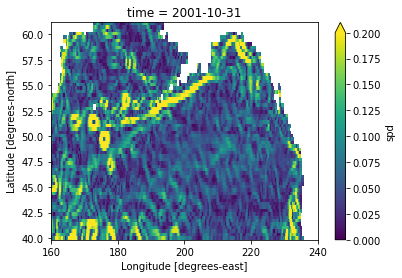

In [91]:
ds_all['spd']=np.sqrt(ds_all.u**2 + ds_all.v**2)
ds_all = ds_all.sel(lon=slice(160,240),lat=slice(61,40))
ds_all.spd[105,:,:].plot(vmin=0,vmax=.2)

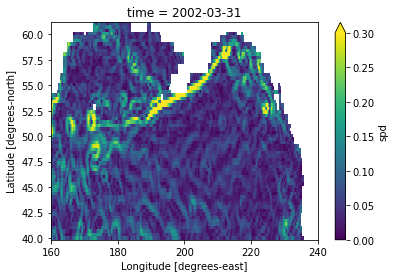

In [112]:
#ds_all2 = ds_all.sel(lon=slice(231,232),lat=50)
#ds_all2 = ds_all.sel(lon=slice(230,235),lat=50)
#print(ds_all2)
#plt.plot(ds_all2.time,ds_all2.spd)
ds_all.spd[110,:,:].plot(vmin=0,vmax=.3)

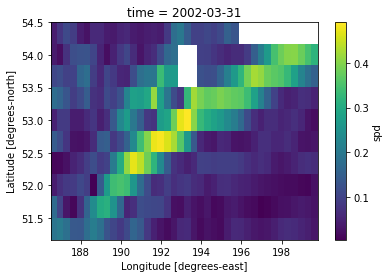

In [132]:
ds_all.spd[110,20:30,80:120].plot()


In [3]:
import xarray as xr
fname='https://podaac-opendap.jpl.nasa.gov:443/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2015/086/20150327090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'
ds=xr.open_dataset(fname)
ds

<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2015-03-27T09:00:00
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -179.99 -179.98 -179.97 ... 179.99 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] ...
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
  